**1. Cài đặt thư viện và thay đổi đường dẫn \(Khi sử dụng google colab)**

In [1]:
!pip install nltk matplotlib py-rouge tqdm shap javalang

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/workspace/DeepCom

/content/drive/.shortcut-targets-by-id/1hQNAblWDSlYAFwpSz5-47rsxwUgg9j3j/workspace/DeepCom


**2. Import thư viện và cài đặt cần thiết**

In [4]:
import nltk

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
import models
import numpy as np
import utils
import data
import shap
import eval
import numpy as np
import matplotlib.pyplot as plt
import config
import os
import train
import pickle
import pickle
_PAD = '<PAD>'
class BeamNode(object):

    def __init__(self, sentence_indices, log_probs, hidden,code_attention=None,ast_attention=None):
        """

        :param sentence_indices: indices of words of current sentence (from root to current node)
        :param log_probs: log prob of node of sentence
        :param hidden: [1, 1, H]
        """
        self.sentence_indices = sentence_indices
        self.log_probs = log_probs
        self.hidden = hidden
        self.code_attention=[] if code_attention is None else code_attention
        self.ast_attention=[] if ast_attention is None else ast_attention

    def extend_node(self, word_index, log_prob, hidden,code_attention=None,ast_attention=None):
        return BeamNode(sentence_indices=self.sentence_indices + [word_index],
                        log_probs=self.log_probs + [log_prob],
                        hidden=hidden,
                        code_attention=self.code_attention+[code_attention],ast_attention=self.ast_attention+[ast_attention])

    def avg_log_prob(self):
        return sum(self.log_probs) / len(self.sentence_indices)

    def word_index(self):
        return self.sentence_indices[-1]
    def attention(self):
        return self.code_attention,self.ast_attention

def beam_decode(model,batch_size, code_outputs: torch.Tensor,
                    ast_outputs: torch.Tensor, decoder_hidden: torch.Tensor):
  batch_sentences = []
  batch_code_attention=[]
  batch_ast_attention=[]
  # B = 1
  for index_batch in range(batch_size):
      # for each input sentence
      single_decoder_hidden = decoder_hidden[:, index_batch, :].unsqueeze(1)  # [1, 1, H]
      single_code_output = code_outputs[:, index_batch, :].unsqueeze(1)  # [T, 1, H]
      single_ast_output = ast_outputs[:, index_batch, :].unsqueeze(1)  # [T, 1, H]
      root = BeamNode(sentence_indices=[utils.get_sos_index(nl_vocab)],
                      log_probs=[0.0],
                      hidden=single_decoder_hidden)

      current_nodes = [root]  # list of nodes to be further extended
      final_nodes = []  # list of end nodes

      for step in range(config.max_decode_steps):
          if len(current_nodes) == 0:
              break

          candidate_nodes = []  # list of nodes to be extended next step

          feed_inputs = []
          feed_hidden = []

          # B = len(current_nodes) except eos
          extend_nodes = []
          for node in current_nodes:
              # if current node is EOS
              if node.word_index() == utils.get_eos_index(nl_vocab):
                  final_nodes.append(node)
                  # if number of final nodes reach the beam width
                  if len(final_nodes) >= config.beam_width:
                      break
                  continue

              extend_nodes.append(node)

              decoder_inputs = node.word_index()
              single_decoder_hidden = node.hidden.clone().detach()     # [1, 1, H]

              feed_inputs.append(decoder_inputs)  # [B]
              feed_hidden.append(single_decoder_hidden)   # B x [1, 1, H]

          if len(extend_nodes) == 0:
              break

          feed_batch_size = len(feed_inputs)
          feed_code_outputs = single_code_output.repeat(1, feed_batch_size, 1)
          feed_ast_outputs = single_ast_output.repeat(1, feed_batch_size, 1)

          feed_inputs = torch.tensor(feed_inputs, device=config.device)   # [B]
          feed_hidden = torch.stack(feed_hidden, dim=2).squeeze(0)    # [1, B, H]

          # decoder_outputs: [B, nl_vocab_size]
          # new_decoder_hidden: [1, B, H]
          # attn_weights: [B, 1, T]
          decoder_outputs, new_decoder_hidden, \
              code_attn_weights, ast_attn_weights = model.decoder(inputs=feed_inputs,
                                                                        last_hidden=feed_hidden,
                                                                        code_outputs=feed_code_outputs,
                                                                        ast_outputs=feed_ast_outputs)

          # get top k words
          # log_probs: [B, beam_width]
          # word_indices: [B, beam_width]
          batch_log_probs, batch_word_indices = decoder_outputs.topk(config.beam_width)

          for index_node, node in enumerate(extend_nodes):
              log_probs = batch_log_probs[index_node]
              word_indices = batch_word_indices[index_node]
              hidden = new_decoder_hidden[:, index_node, :].unsqueeze(1)
              code_attention=code_attn_weights[index_node,:,:]
              ast_attention=ast_attn_weights[index_node,:,:]
              for i in range(config.beam_width):
                  log_prob = log_probs[i]
                  word_index = word_indices[i].item()

                  new_node = node.extend_node(word_index=word_index,
                                              log_prob=log_prob,
                                              hidden=hidden,
                                              code_attention=code_attention,
                                              ast_attention=ast_attention)
                  candidate_nodes.append(new_node)

          # sort candidate nodes by log_prb and select beam_width nodes
          candidate_nodes = sorted(candidate_nodes, key=lambda item: item.avg_log_prob(), reverse=True)
          current_nodes = candidate_nodes[: config.beam_width]

      final_nodes += current_nodes
      final_nodes = sorted(final_nodes, key=lambda item: item.avg_log_prob(), reverse=True)
      final_nodes = final_nodes[: config.beam_top_sentences]

      sentences = []
      code_attention = []
      ast_attention=[]
      for final_node in final_nodes:
          sentences.append(final_node.sentence_indices)
      for final_node in final_nodes:
          code_attention.append(final_node.code_attention)
      for final_node in final_nodes:
          ast_attention.append(final_node.ast_attention)
      batch_sentences.append(sentences)
      batch_code_attention.append(code_attention)
      batch_ast_attention.append(ast_attention)
  #longest_senteces=max(len(sentences[0]) for sentences in batch_sentences)
  #for sentence in batch_sentences:
  #  while len(sentence[0])<longest_senteces:
  #    sentence[0].append(nl_vocab.word2index[_PAD])
  #print(batch_sentences)

  return batch_sentences,batch_code_attention,batch_ast_attention

def translate_indices(batch_sentences,batch_code_attentions,batch_ast_attentions):
  batch_words = []
  batch_code_attention=[]
  batch_ast_attention=[]
  #print(batch_sentences)
  for idxx,sentences in enumerate(batch_sentences):
      code_attentions=batch_code_attentions[idxx]
      ast_attentions=batch_ast_attentions[idxx]
      words = []
      code_attention=[]
      ast_attention=[]
      #print(code_attentions)
      for idx,indices in enumerate(sentences):
          #print(code_attentions[idx])
          for idx1,index in enumerate(indices):
              word = nl_vocab.index2word[index]
              if utils.is_unk(word) or not utils.is_special_symbol(word):
                  words.append(word)
                  code_attention.append(code_attentions[idx][idx1])
                  ast_attention.append(ast_attentions[idx][idx1])
      batch_words.append(' '.join(words))
      batch_code_attention.append(code_attention)
      batch_ast_attention.append(ast_attention)
  return batch_words, batch_code_attention,batch_ast_attention

code_vocab = utils.load_vocab_pk(config.code_vocab_path)
ast_vocab = utils.load_vocab_pk(config.ast_vocab_path)
nl_vocab = utils.load_vocab_pk(config.nl_vocab_path)
code_vocab_size = len(code_vocab)
ast_vocab_size = len(ast_vocab)
nl_vocab_size = len(nl_vocab)
dataset_dir = "../dataset_v2/"


INFO:root:Configurations this run are shown below.
INFO:root:Notes: If only runs test, the model configurations shown above is not the configurations of the model test runs on.
INFO:root:
INFO:root:Features and limitations:
INFO:root:dataset_dir: ../dataset_v2
INFO:root:use_cuda: True
INFO:root:device: cuda
INFO:root:use_coverage: False
INFO:root:use_pointer_gen: False
INFO:root:use_teacher_forcing: True
INFO:root:use_lr_decay: True
INFO:root:use_early_stopping: True
INFO:root:max_code_length: 313
INFO:root:max_nl_length: 30
INFO:root:min_nl_length: 4
INFO:root:max_decode_steps: 30
INFO:root:early_stopping_patience: 5
INFO:root:
INFO:root:Train configurations:
INFO:root:embedding_dim: 256
INFO:root:hidden_size: 256
INFO:root:decoder_dropout_rate: 0.5
INFO:root:teacher_forcing_ratio: 0.5
INFO:root:batch_size: 32
INFO:root:code_encoder_lr: 0.001
INFO:root:ast_encoder_lr: 0.001
INFO:root:reduce_hidden_lr: 0.001
INFO:root:decoder_lr: 0.0001
INFO:root:lr_decay_every: 1
INFO:root:lr_decay_ra

**3. Minh họa attention**

In [23]:
def visualize_attention(x,model,code_vocab,ast_vocab,nl_vocab,limit_meteor_score=None,save_image_path=None,ast=False):
    x_temp=[[x]]
    code_original=x[0]
    ast_original=x[1]
    comment_original=x[2]
    x=utils.unsort_collate_fn(x_temp,code_vocab,ast_vocab,nl_vocab)
    code_outputs, ast_outputs, decoder_hidden = model(x, 1, nl_vocab, is_test=True)
    batch_sentences,code_attention,ast_attention = beam_decode(model=model,batch_size=1,
                                                  code_outputs=code_outputs,
                                                  ast_outputs=ast_outputs,
                                                  decoder_hidden=decoder_hidden)

                # translate indices into words both for candidates
    candidates,code_attention_res,ast_attention_res = translate_indices(batch_sentences,code_attention,ast_attention)

    res=torch.cat(code_attention_res[0],0)
    res_1=torch.cat(ast_attention_res[0],0)
    '''
    fig, ax = plt.subplots(2, figsize=(40, 20))
    #fig.subplots_adjust(wspace=0.25)
    ax[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[0].set_xticks(range(len(code_original)), code_original, rotation=90)
    ax[0].set_yticks(range(len(candidates[0].split())), candidates[0].split())
    numpy_array=res.detach().cpu().numpy()
    numpy_array=numpy_array[:,:-1]
    ax[0].imshow( numpy_array ,cmap='Greys')
    ax[1].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[1].set_xticks(range(len(ast_original)), ast_original, rotation=90)
    ax[1].set_yticks(range(len(candidates[0].split())), candidates[0].split())
    numpy_array_1=res_1.detach().cpu().numpy()
    numpy_array_1=numpy_array_1[:,:-1]
    ax[1].imshow( numpy_array_1 ,cmap='Greys')
    '''
    if ast:
      fig,ax=plt.subplots()
    else:
      fig,ax=plt.subplots()
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    if ast:
      ax.set_xticks(range(len(ast_original)), ast_original,rotation=90)
      ax.set_yticks(range(len(candidates[0].split())), candidates[0].split())
    else:
      ax.set_xticks(range(len(code_original)), code_original, rotation=80)
      ax.set_yticks(range(len(candidates[0].split())), candidates[0].split())
    if ast:
      numpy_array=res_1.detach().cpu().numpy()
    else:
      numpy_array=res.detach().cpu().numpy()
    numpy_array=numpy_array[:,:-1]
    ax.imshow( numpy_array ,cmap='Greys')
    meteor_score=utils.meteor_score(comment_original,candidates[0].split())
    if save_image_path is not None and (limit_meteor_score is None or meteor_score>=limit_meteor_score):
        fig.savefig(save_image_path)
    else:
        plt.show()



In [7]:
def get_attention_by_project(project,num_data,num_fold,item=None,save_image_meta=None,save_image_baseline=None,ast=False):
  project2sources = { #ranking
      'spring-boot': ['spring-framework', 'dubbo', 'flink', 'kafka', 'spring-security', 'guava', 'ExoPlayer'],
      'spring-framework': ['spring-boot', 'dubbo', 'flink', 'spring-security', 'kafka', 'ExoPlayer', 'guava'],
      'spring-security': ['spring-framework', 'spring-boot', 'dubbo', 'kafka', 'flink', 'ExoPlayer' ,'guava'],
      'guava': ['flink', 'dubbo', 'spring-framework', 'kafka', 'ExoPlayer', 'spring-boot', 'dagger'],
      'ExoPlayer': ['flink', 'spring-framework', 'guava', 'kafka', 'spring-boot', 'dubbo', 'spring-security'],
      'kafka': ['flink', 'spring-boot', 'spring-framework', 'dubbo', 'guava', 'ExoPlayer', 'spring-security'],
      'dubbo': ['spring-framework', 'spring-boot', 'flink', 'kafka', 'guava', 'spring-security', 'dagger'],
      'flink': ['kafka', 'spring-framework', 'dubbo', 'spring-boot', 'guava', 'ExoPlayer', 'spring-security'],
  }
  project2path={
      'dubbo':'model/dubbo_meta_3/best_epoch-0.pt',
      'spring-boot':'model/spring-boot_meta_3/best_epoch-3.pt',
      'spring-security': 'model/spring-security_meta_3/best_epoch-0.pt',
      'guava': 'model/guava_meta_3/best_epoch-1.pt',
      'ExoPlayer':'model/ExoPlayer_meta_3/best_epoch-4.pt',
      'kafka':'model/kafka_meta_3/best_epoch-1.pt',
      'flink': 'model/flink_meta_3/best_epoch-4.pt',
      'spring-framework':'model/spring-framework_meta_3/best_epoch-0.pt',
  }
  with open(f'../dataset_v2/original/{project}/all_unpreprocess.code', 'rb') as handle:
      code_dict = pickle.loads(handle.read())
  with open(f'../dataset_v2/original/{project}/all_truncated_unlowered_dict.code', 'rb') as handle1:
      code_dict_unlowerd = pickle.loads(handle1.read())
  validating_project=project2sources[project][3]
  train_instance = train.Train(vocab_file_path=(config.code_vocab_path, config.ast_vocab_path, config.nl_vocab_path),model_file_path=project2path[project],
                                    code_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.code')
                                    ,ast_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.sbt'),
                                    nl_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.comment'),batch_size=config.support_batch_size,
                                    code_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.code'),nl_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.comment'),
                                          ast_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated.sbt')
                                          ,num_of_data=num_data,save_file=False,seed=0,is_test=True)
  best_model_test_dict=train_instance.run_train()
  train_instance_baseline = train.Train(vocab_file_path=(config.code_vocab_path, config.ast_vocab_path, config.nl_vocab_path),model_file_path=f'model/{project}_base_3/best_epoch-0_batch-last.pt',
                                    code_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.code')
                                    ,ast_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.sbt'),
                                    nl_path=os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_train.comment'),batch_size=config.support_batch_size,
                                    code_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.code'),nl_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated_final.comment'),
                                          ast_valid_path=os.path.join(dataset_dir,f'original/{validating_project}/all_truncated.sbt')
                                          ,num_of_data=num_data,save_file=False,seed=0,is_test=True)
  best_model_test_dict_baseline=train_instance_baseline.run_train()
  model_meta=models.Model(code_vocab_size=code_vocab_size,
                                ast_vocab_size=ast_vocab_size,
                                nl_vocab_size=nl_vocab_size,
                                model_state_dict=best_model_test_dict
                                ,is_eval=True)
  model_baseline=models.Model(code_vocab_size=code_vocab_size,
                                ast_vocab_size=ast_vocab_size,
                                nl_vocab_size=nl_vocab_size,
                                model_state_dict=best_model_test_dict_baseline
                                ,is_eval=True)

  dataset_test = data.CodePtrDataset(os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.code'),
                                      os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.sbt'),
                                      os.path.join(dataset_dir,f'original/{project}/fold_{num_fold}_test.comment'))
  #x=dataset_test.__getitem__(181)
  #visualize_attention(x,model,code_vocab,ast_vocab,nl_vocab,f'result_images/guava/{181}.png')
  if item is not None:
    x=dataset_test.__getitem__(item)
    print('MAML: ')
    visualize_attention(x,model_meta,code_vocab,ast_vocab,nl_vocab,None,save_image_meta,ast=ast)
    print('Baseline: ')
    visualize_attention(x,model_baseline,code_vocab,ast_vocab,nl_vocab,None,save_image_baseline,ast=ast)
  else:
    for i in range(len(dataset_test)):
      x=dataset_test.__getitem__(i)
      print('MAML: ')
      visualize_attention(x,model_meta,code_vocab,ast_vocab,nl_vocab,ast=ast)
      print('Baseline: ')
      visualize_attention(x,model_baseline,code_vocab,ast_vocab,nl_vocab,ast=ast)

INFO:root:Epoch 1, batch 0: 4.565257549285889
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 4.5653
INFO:root:Epoch 1, batch 0/16: 4.565257549285889
INFO:root:Epoch 1, batch 1: 4.966249942779541


time:  0h  0min  0s 205ms, remaining:  0h  1min  2s 578ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 4.5653
Epoch 1, batch 0/16: 4.565257549285889


INFO:root:Epoch 1, batch 2: 5.441259860992432
INFO:root:Epoch 1, batch 3: 4.824594497680664
INFO:root:Epoch 1, batch 4: 4.95149040222168
INFO:root:Epoch 1, batch 5: 5.741037368774414
INFO:root:Epoch 1, batch 6: 5.48021936416626
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9867.
INFO:root:Epoch 2, batch 0: 2.611232042312622
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.6112
INFO:root:Epoch 2, batch 0/16: 2.611232042312622


Validate completed, avg loss: 4.9867.

time:  0h  0min  4s 341ms, remaining:  0h  3min  2s 284ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.6112
Epoch 2, batch 0/16: 2.611232042312622


INFO:root:Epoch 2, batch 1: 3.0897181034088135
INFO:root:Epoch 2, batch 2: 3.8637263774871826
INFO:root:Epoch 2, batch 3: 3.7549045085906982
INFO:root:Epoch 2, batch 4: 3.5983474254608154
INFO:root:Epoch 2, batch 5: 4.558462619781494
INFO:root:Epoch 2, batch 6: 3.1944563388824463
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0393.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.0610594749450684
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.0611
INFO:root:Epoch 3, batch 0/16: 2.0610594749450684


Validate completed, avg loss: 5.0393.

EarlyStopping counter: 1 out of 5.

time:  0h  0min  8s 879ms, remaining:  0h  3min 16s 353ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.0611
Epoch 3, batch 0/16: 2.0610594749450684


INFO:root:Epoch 3, batch 1: 2.356667995452881
INFO:root:Epoch 3, batch 2: 2.80879545211792
INFO:root:Epoch 3, batch 3: 2.660041570663452
INFO:root:Epoch 3, batch 4: 3.160120725631714
INFO:root:Epoch 3, batch 5: 3.899604082107544
INFO:root:Epoch 3, batch 6: 2.3722984790802
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0977.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.4962140321731567
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.4962
INFO:root:Epoch 4, batch 0/16: 1.4962140321731567


Validate completed, avg loss: 5.0977.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 13s  67ms, remaining:  0h  3min 13s 488ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.4962
Epoch 4, batch 0/16: 1.4962140321731567


INFO:root:Epoch 4, batch 1: 1.9536207914352417
INFO:root:Epoch 4, batch 2: 1.796789526939392
INFO:root:Epoch 4, batch 3: 2.0160324573516846
INFO:root:Epoch 4, batch 4: 2.4626035690307617
INFO:root:Epoch 4, batch 5: 2.8629441261291504
INFO:root:Epoch 4, batch 6: 1.620280385017395
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1747.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.057890772819519
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.0579
INFO:root:Epoch 5, batch 0/16: 1.057890772819519


Validate completed, avg loss: 5.1747.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 17s 271ms, remaining:  0h  3min 10s 154ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.0579
Epoch 5, batch 0/16: 1.057890772819519


INFO:root:Epoch 5, batch 1: 1.5402274131774902
INFO:root:Epoch 5, batch 2: 1.2399617433547974
INFO:root:Epoch 5, batch 3: 1.4273931980133057
INFO:root:Epoch 5, batch 4: 1.8860958814620972
INFO:root:Epoch 5, batch 5: 2.242668628692627
INFO:root:Epoch 5, batch 6: 0.9956861138343811
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2393.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.7098202705383301
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7098
INFO:root:Epoch 6, batch 0/16: 0.7098202705383301


Validate completed, avg loss: 5.2393.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 21s 752ms, remaining:  0h  3min  8s 896ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7098
Epoch 6, batch 0/16: 0.7098202705383301


INFO:root:Epoch 6, batch 1: 1.0640712976455688
INFO:root:Epoch 6, batch 2: 1.0246448516845703
INFO:root:Epoch 6, batch 3: 1.151548981666565
INFO:root:Epoch 6, batch 4: 1.402579665184021
INFO:root:Epoch 6, batch 5: 1.7570091485977173
INFO:root:Epoch 6, batch 6: 0.945101261138916
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3141.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.3141.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.361385345458984
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.3614
INFO:root:Epoch 1, batch 0/16: 5.361385345458984


time:  0h  0min  0s 208ms, remaining:  0h  1min  3s 734ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.3614
Epoch 1, batch 0/16: 5.361385345458984


INFO:root:Epoch 1, batch 1: 5.195060729980469
INFO:root:Epoch 1, batch 2: 5.488667964935303
INFO:root:Epoch 1, batch 3: 5.338207244873047
INFO:root:Epoch 1, batch 4: 5.620096206665039
INFO:root:Epoch 1, batch 5: 6.342580318450928
INFO:root:Epoch 1, batch 6: 6.2807159423828125
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4586.
INFO:root:Epoch 2, batch 0: 3.275956869125366
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 3.2760
INFO:root:Epoch 2, batch 0/16: 3.275956869125366


Validate completed, avg loss: 5.4586.

time:  0h  0min  4s 503ms, remaining:  0h  3min  9s  77ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 3.2760
Epoch 2, batch 0/16: 3.275956869125366


INFO:root:Epoch 2, batch 1: 3.4755609035491943
INFO:root:Epoch 2, batch 2: 3.988724708557129
INFO:root:Epoch 2, batch 3: 4.062846660614014
INFO:root:Epoch 2, batch 4: 4.1401214599609375
INFO:root:Epoch 2, batch 5: 4.929018497467041
INFO:root:Epoch 2, batch 6: 4.004624366760254
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4039.
INFO:root:Epoch 3, batch 0: 2.373081922531128
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.3731
INFO:root:Epoch 3, batch 0/16: 2.373081922531128


Validate completed, avg loss: 5.4039.

time:  0h  0min  9s 137ms, remaining:  0h  3min 22s  65ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.3731
Epoch 3, batch 0/16: 2.373081922531128


INFO:root:Epoch 3, batch 1: 2.453951835632324
INFO:root:Epoch 3, batch 2: 3.0042309761047363
INFO:root:Epoch 3, batch 3: 2.8782782554626465
INFO:root:Epoch 3, batch 4: 3.0042037963867188
INFO:root:Epoch 3, batch 5: 3.982945203781128
INFO:root:Epoch 3, batch 6: 2.261465549468994
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4268.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 4, batch 0: 1.6070977449417114
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.6071
INFO:root:Epoch 4, batch 0/16: 1.6070977449417114


Validate completed, avg loss: 5.4268.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 13s 432ms, remaining:  0h  3min 18s 886ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.6071
Epoch 4, batch 0/16: 1.6070977449417114


INFO:root:Epoch 4, batch 1: 1.6756010055541992
INFO:root:Epoch 4, batch 2: 2.1287832260131836
INFO:root:Epoch 4, batch 3: 2.627075433731079
INFO:root:Epoch 4, batch 4: 2.661447048187256
INFO:root:Epoch 4, batch 5: 3.641855239868164
INFO:root:Epoch 4, batch 6: 1.3210111856460571
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4422.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 5, batch 0: 1.3033946752548218
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.3034
INFO:root:Epoch 5, batch 0/16: 1.3033946752548218


Validate completed, avg loss: 5.4422.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 17s 790ms, remaining:  0h  3min 15s 872ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.3034
Epoch 5, batch 0/16: 1.3033946752548218


INFO:root:Epoch 5, batch 1: 1.2662603855133057
INFO:root:Epoch 5, batch 2: 1.4366605281829834
INFO:root:Epoch 5, batch 3: 1.8631161451339722
INFO:root:Epoch 5, batch 4: 1.8809362649917603
INFO:root:Epoch 5, batch 5: 2.954932928085327
INFO:root:Epoch 5, batch 6: 0.8914727568626404
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5058.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 6, batch 0: 0.7359707951545715
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7360
INFO:root:Epoch 6, batch 0/16: 0.7359707951545715


Validate completed, avg loss: 5.5058.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 22s 474ms, remaining:  0h  3min 15s 163ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7360
Epoch 6, batch 0/16: 0.7359707951545715


INFO:root:Epoch 6, batch 1: 1.182511568069458
INFO:root:Epoch 6, batch 2: 0.9007622003555298
INFO:root:Epoch 6, batch 3: 1.1963645219802856
INFO:root:Epoch 6, batch 4: 1.9208117723464966
INFO:root:Epoch 6, batch 5: 2.168076992034912
INFO:root:Epoch 6, batch 6: 1.288365125656128
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5695.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 7, batch 0: 0.4733405113220215
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.4733
INFO:root:Epoch 7, batch 0/16: 0.4733405113220215


Validate completed, avg loss: 5.5695.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 26s 822ms, remaining:  0h  3min 10s 778ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.4733
Epoch 7, batch 0/16: 0.4733405113220215


INFO:root:Epoch 7, batch 1: 0.6216421723365784
INFO:root:Epoch 7, batch 2: 0.5188450813293457
INFO:root:Epoch 7, batch 3: 0.9817452430725098
INFO:root:Epoch 7, batch 4: 1.1796307563781738
INFO:root:Epoch 7, batch 5: 1.8285996913909912
INFO:root:Epoch 7, batch 6: 0.3478472828865051
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6293.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6293.

EarlyStopping counter: 5 out of 5.

Early stop.

MAML: 
Baseline: 


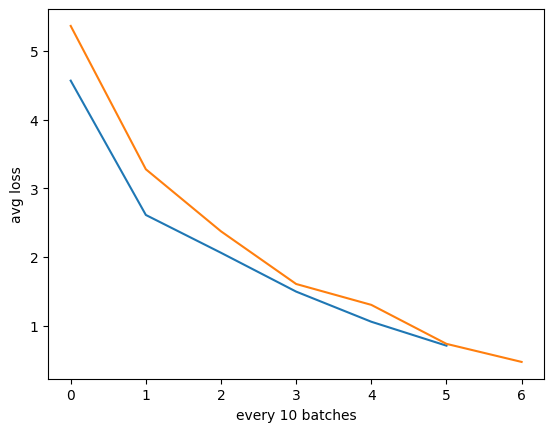

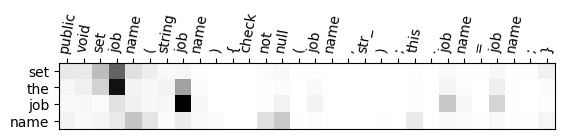

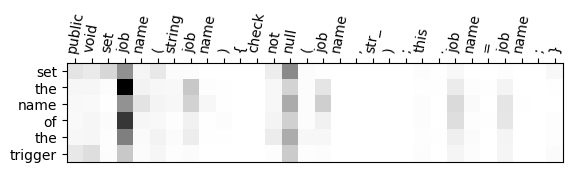

In [ ]:
get_attention_by_project('flink',100,0,181,'./result_images/flink_meta_100_0_181.pdf','./result_images/flink_baseline_100_0_181.pdf')

INFO:root:Epoch 1, batch 0: 4.793586254119873
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 4.7936
INFO:root:Epoch 1, batch 0/16: 4.793586254119873


time:  0h  0min  0s 219ms, remaining:  0h  1min  6s 929ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 4.7936
Epoch 1, batch 0/16: 4.793586254119873


INFO:root:Epoch 1, batch 1: 5.024664402008057
INFO:root:Epoch 1, batch 2: 4.858006477355957
INFO:root:Epoch 1, batch 3: 5.383723258972168
INFO:root:Epoch 1, batch 4: 4.760840892791748
INFO:root:Epoch 1, batch 5: 5.619877338409424
INFO:root:Epoch 1, batch 6: 5.611396789550781
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9666.
INFO:root:Epoch 2, batch 0: 2.8333277702331543
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.8333
INFO:root:Epoch 2, batch 0/16: 2.8333277702331543


Validate completed, avg loss: 4.9666.

time:  0h  0min  4s 931ms, remaining:  0h  3min 27s  52ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.8333
Epoch 2, batch 0/16: 2.8333277702331543


INFO:root:Epoch 2, batch 1: 3.117300271987915
INFO:root:Epoch 2, batch 2: 3.5449130535125732
INFO:root:Epoch 2, batch 3: 3.689790725708008
INFO:root:Epoch 2, batch 4: 3.869710922241211
INFO:root:Epoch 2, batch 5: 4.4239373207092285
INFO:root:Epoch 2, batch 6: 3.337364912033081
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0261.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.063615322113037
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.0636
INFO:root:Epoch 3, batch 0/16: 2.063615322113037


Validate completed, avg loss: 5.0261.

EarlyStopping counter: 1 out of 5.

time:  0h  0min  9s 335ms, remaining:  0h  3min 26s 440ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.0636
Epoch 3, batch 0/16: 2.063615322113037


INFO:root:Epoch 3, batch 1: 2.7604665756225586
INFO:root:Epoch 3, batch 2: 2.6286232471466064
INFO:root:Epoch 3, batch 3: 3.11616849899292
INFO:root:Epoch 3, batch 4: 2.9350104331970215
INFO:root:Epoch 3, batch 5: 4.013908386230469
INFO:root:Epoch 3, batch 6: 2.03527569770813
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0910.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.3472377061843872
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.3472
INFO:root:Epoch 4, batch 0/16: 1.3472377061843872


Validate completed, avg loss: 5.0910.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 13s 815ms, remaining:  0h  3min 24s 560ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.3472
Epoch 4, batch 0/16: 1.3472377061843872


INFO:root:Epoch 4, batch 1: 1.7528318166732788
INFO:root:Epoch 4, batch 2: 1.801630973815918
INFO:root:Epoch 4, batch 3: 2.3277604579925537
INFO:root:Epoch 4, batch 4: 2.5751569271087646
INFO:root:Epoch 4, batch 5: 2.88812255859375
INFO:root:Epoch 4, batch 6: 1.8157809972763062
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1474.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.1639692783355713
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.1640
INFO:root:Epoch 5, batch 0/16: 1.1639692783355713


Validate completed, avg loss: 5.1474.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 18s 626ms, remaining:  0h  3min 25s  69ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.1640
Epoch 5, batch 0/16: 1.1639692783355713


INFO:root:Epoch 5, batch 1: 1.2058136463165283
INFO:root:Epoch 5, batch 2: 1.5211162567138672
INFO:root:Epoch 5, batch 3: 1.7019610404968262
INFO:root:Epoch 5, batch 4: 1.843612551689148
INFO:root:Epoch 5, batch 5: 1.9761592149734497
INFO:root:Epoch 5, batch 6: 1.8420368432998657
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2155.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.668171226978302
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.6682
INFO:root:Epoch 6, batch 0/16: 0.668171226978302


Validate completed, avg loss: 5.2155.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 23s  77ms, remaining:  0h  3min 20s 402ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.6682
Epoch 6, batch 0/16: 0.668171226978302


INFO:root:Epoch 6, batch 1: 1.0901449918746948
INFO:root:Epoch 6, batch 2: 1.3059684038162231
INFO:root:Epoch 6, batch 3: 1.1700091361999512
INFO:root:Epoch 6, batch 4: 1.427243947982788
INFO:root:Epoch 6, batch 5: 2.041471481323242
INFO:root:Epoch 6, batch 6: 1.4332290887832642
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2690.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.2690.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.494290351867676
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.4943
INFO:root:Epoch 1, batch 0/16: 5.494290351867676


time:  0h  0min  0s 204ms, remaining:  0h  1min  2s 275ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.4943
Epoch 1, batch 0/16: 5.494290351867676


INFO:root:Epoch 1, batch 1: 5.724609375
INFO:root:Epoch 1, batch 2: 5.386053562164307
INFO:root:Epoch 1, batch 3: 5.690939426422119
INFO:root:Epoch 1, batch 4: 5.189314365386963
INFO:root:Epoch 1, batch 5: 6.171000957489014
INFO:root:Epoch 1, batch 6: 6.490727424621582
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4090.
INFO:root:Epoch 2, batch 0: 3.0439202785491943
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 3.0439
INFO:root:Epoch 2, batch 0/16: 3.0439202785491943


Validate completed, avg loss: 5.4090.

time:  0h  0min  4s 716ms, remaining:  0h  3min 18s  30ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 3.0439
Epoch 2, batch 0/16: 3.0439202785491943


INFO:root:Epoch 2, batch 1: 4.038215160369873
INFO:root:Epoch 2, batch 2: 4.014558792114258
INFO:root:Epoch 2, batch 3: 4.142535209655762
INFO:root:Epoch 2, batch 4: 4.09485387802124
INFO:root:Epoch 2, batch 5: 4.992831707000732
INFO:root:Epoch 2, batch 6: 3.733272075653076
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3878.
INFO:root:Epoch 3, batch 0: 2.2648088932037354
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.2648
INFO:root:Epoch 3, batch 0/16: 2.2648088932037354


Validate completed, avg loss: 5.3878.

time:  0h  0min  9s 203ms, remaining:  0h  3min 23s 519ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.2648
Epoch 3, batch 0/16: 2.2648088932037354


INFO:root:Epoch 3, batch 1: 2.9943573474884033
INFO:root:Epoch 3, batch 2: 2.8247246742248535
INFO:root:Epoch 3, batch 3: 3.3373076915740967
INFO:root:Epoch 3, batch 4: 3.2477142810821533
INFO:root:Epoch 3, batch 5: 3.7195534706115723
INFO:root:Epoch 3, batch 6: 3.2108254432678223
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4183.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 4, batch 0: 1.8733882904052734
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.8734
INFO:root:Epoch 4, batch 0/16: 1.8733882904052734


Validate completed, avg loss: 5.4183.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 14s  75ms, remaining:  0h  3min 28s 408ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.8734
Epoch 4, batch 0/16: 1.8733882904052734


INFO:root:Epoch 4, batch 1: 2.42806339263916
INFO:root:Epoch 4, batch 2: 2.558593511581421
INFO:root:Epoch 4, batch 3: 2.399275541305542
INFO:root:Epoch 4, batch 4: 2.505197286605835
INFO:root:Epoch 4, batch 5: 3.201115846633911
INFO:root:Epoch 4, batch 6: 1.469426155090332
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4489.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 5, batch 0: 1.0614981651306152
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.0615
INFO:root:Epoch 5, batch 0/16: 1.0614981651306152


Validate completed, avg loss: 5.4489.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 18s 561ms, remaining:  0h  3min 24s 356ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.0615
Epoch 5, batch 0/16: 1.0614981651306152


INFO:root:Epoch 5, batch 1: 1.5804299116134644
INFO:root:Epoch 5, batch 2: 1.849387288093567
INFO:root:Epoch 5, batch 3: 1.9277894496917725
INFO:root:Epoch 5, batch 4: 2.164278507232666
INFO:root:Epoch 5, batch 5: 3.1572115421295166
INFO:root:Epoch 5, batch 6: 1.8836240768432617
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5040.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 6, batch 0: 0.8203873038291931
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.8204
INFO:root:Epoch 6, batch 0/16: 0.8203873038291931


Validate completed, avg loss: 5.5040.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 23s  26ms, remaining:  0h  3min 19s 960ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.8204
Epoch 6, batch 0/16: 0.8203873038291931


INFO:root:Epoch 6, batch 1: 1.1164162158966064
INFO:root:Epoch 6, batch 2: 1.1355855464935303
INFO:root:Epoch 6, batch 3: 1.7366129159927368
INFO:root:Epoch 6, batch 4: 1.427481770515442
INFO:root:Epoch 6, batch 5: 2.093977212905884
INFO:root:Epoch 6, batch 6: 1.326583743095398
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5540.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 7, batch 0: 0.4668348729610443
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.4668
INFO:root:Epoch 7, batch 0/16: 0.4668348729610443


Validate completed, avg loss: 5.5540.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 27s 855ms, remaining:  0h  3min 18s 126ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.4668
Epoch 7, batch 0/16: 0.4668348729610443


INFO:root:Epoch 7, batch 1: 0.8523613214492798
INFO:root:Epoch 7, batch 2: 0.7802656292915344
INFO:root:Epoch 7, batch 3: 1.1863131523132324
INFO:root:Epoch 7, batch 4: 1.5458186864852905
INFO:root:Epoch 7, batch 5: 1.565264344215393
INFO:root:Epoch 7, batch 6: 0.6752466559410095
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6097.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6097.

EarlyStopping counter: 5 out of 5.

Early stop.

MAML: 
Baseline: 


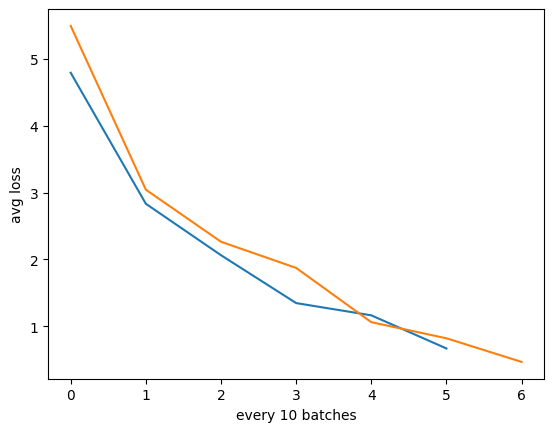

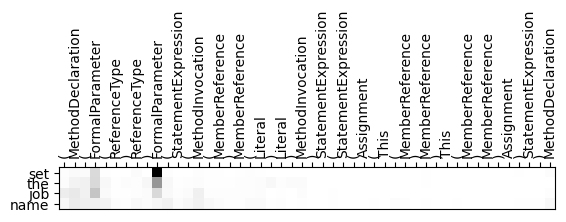

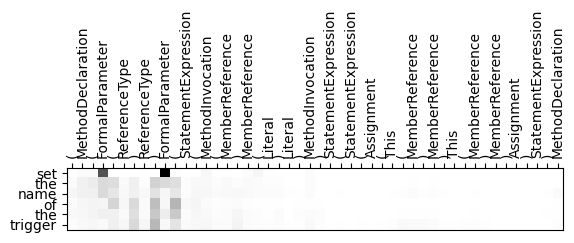

In [30]:
get_attention_by_project('flink',100,0,181,'./result_images/flink_meta_100_0_181_ast.pdf','./result_images/flink_baseline_100_0_181_ast.pdf',True)

INFO:root:Epoch 1, batch 0: 4.838161945343018
INFO:root:epoch: 1/50, batch: 0/12, avg loss: 4.8382
INFO:root:Epoch 1, batch 0/16: 4.838161945343018


time:  0h  0min  0s 195ms, remaining:  0h  3min 57s 295ms, epoch:  1/50, batch:  0/12, percent complete:   0.08%, avg loss: 4.8382
Epoch 1, batch 0/16: 4.838161945343018


INFO:root:Epoch 1, batch 1: 4.954337120056152
INFO:root:Epoch 1, batch 2: 5.334076404571533
INFO:root:Epoch 1, batch 3: 5.021461009979248
INFO:root:Epoch 1, batch 4: 4.743349075317383
INFO:root:Epoch 1, batch 5: 5.707622528076172
INFO:root:Epoch 1, batch 6: 5.531663417816162
INFO:root:Epoch 1, batch 7: 5.674394607543945
INFO:root:Epoch 1, batch 8: 5.13041353225708
INFO:root:Epoch 1, batch 9: 5.518092155456543
INFO:root:Epoch 1, batch 10: 5.188002109527588
INFO:root:Epoch 1, batch 11: 4.720458984375
INFO:root:Epoch 1, batch 12: 5.308498859405518
INFO:root:Epoch 1, batch 13: 5.418187141418457
INFO:root:Epoch 1, batch 14: 5.119688987731934
INFO:root:Epoch 1, batch 15: 4.985753059387207
INFO:root:Epoch 1, batch 16: 5.229535102844238
INFO:root:Epoch 1, batch 17: 5.476597309112549
INFO:root:Epoch 1, batch 18: 5.3291215896606445
INFO:root:Epoch 1, batch 19: 4.885552883148193
INFO:root:Epoch 1, batch 20: 5.5582075119018555
INFO:root:Epoch 1, batch 21: 4.771005153656006
INFO:root:Epoch 1, batch


Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0047.
INFO:root:Epoch 2, batch 0: 2.885500907897949
INFO:root:epoch: 2/50, batch: 0/12, avg loss: 2.8855
INFO:root:Epoch 2, batch 0/16: 2.885500907897949


Validate completed, avg loss: 5.0047.

time:  0h  0min  7s 784ms, remaining:  0h  6min  6s  47ms, epoch:  2/50, batch:  0/12, percent complete:   2.08%, avg loss: 2.8855
Epoch 2, batch 0/16: 2.885500907897949


INFO:root:Epoch 2, batch 1: 3.17844557762146
INFO:root:Epoch 2, batch 2: 3.412752389907837
INFO:root:Epoch 2, batch 3: 3.3150970935821533
INFO:root:Epoch 2, batch 4: 3.320894956588745
INFO:root:Epoch 2, batch 5: 3.9922385215759277
INFO:root:Epoch 2, batch 6: 3.7002909183502197
INFO:root:Epoch 2, batch 7: 3.8998422622680664
INFO:root:Epoch 2, batch 8: 3.6115524768829346
INFO:root:Epoch 2, batch 9: 4.021778106689453
INFO:root:Epoch 2, batch 10: 3.6702513694763184
INFO:root:Epoch 2, batch 11: 3.3787496089935303
INFO:root:Epoch 2, batch 12: 4.124844551086426
INFO:root:Epoch 2, batch 13: 3.7419726848602295
INFO:root:Epoch 2, batch 14: 3.7651004791259766
INFO:root:Epoch 2, batch 15: 3.6182589530944824
INFO:root:Epoch 2, batch 16: 4.409669876098633
INFO:root:Epoch 2, batch 17: 3.8880879878997803
INFO:root:Epoch 2, batch 18: 4.406420707702637
INFO:root:Epoch 2, batch 19: 3.3628361225128174
INFO:root:Epoch 2, batch 20: 4.384144306182861
INFO:root:Epoch 2, batch 21: 3.993779420852661
INFO:root:E


Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0979.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 1.9103926420211792
INFO:root:epoch: 3/50, batch: 0/12, avg loss: 1.9104
INFO:root:Epoch 3, batch 0/16: 1.9103926420211792


Validate completed, avg loss: 5.0979.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 15s 366ms, remaining:  0h  6min  1s  61ms, epoch:  3/50, batch:  0/12, percent complete:   4.08%, avg loss: 1.9104
Epoch 3, batch 0/16: 1.9103926420211792


INFO:root:Epoch 3, batch 1: 2.1148905754089355
INFO:root:Epoch 3, batch 2: 2.7181499004364014
INFO:root:Epoch 3, batch 3: 2.4806976318359375
INFO:root:Epoch 3, batch 4: 2.510906934738159
INFO:root:Epoch 3, batch 5: 3.2304396629333496
INFO:root:Epoch 3, batch 6: 3.2246577739715576
INFO:root:Epoch 3, batch 7: 3.0969178676605225
INFO:root:Epoch 3, batch 8: 2.888305425643921
INFO:root:Epoch 3, batch 9: 3.64023756980896
INFO:root:Epoch 3, batch 10: 2.8477227687835693
INFO:root:Epoch 3, batch 11: 2.5880753993988037
INFO:root:Epoch 3, batch 12: 3.0988993644714355
INFO:root:Epoch 3, batch 13: 2.6035070419311523
INFO:root:Epoch 3, batch 14: 2.9587814807891846
INFO:root:Epoch 3, batch 15: 2.684276580810547
INFO:root:Epoch 3, batch 16: 2.535367488861084
INFO:root:Epoch 3, batch 17: 3.0514848232269287
INFO:root:Epoch 3, batch 18: 3.0519983768463135
INFO:root:Epoch 3, batch 19: 2.7283833026885986
INFO:root:Epoch 3, batch 20: 3.564208984375
INFO:root:Epoch 3, batch 21: 3.0995137691497803
INFO:root:E


Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2824.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.1537505388259888
INFO:root:epoch: 4/50, batch: 0/12, avg loss: 1.1538
INFO:root:Epoch 4, batch 0/16: 1.1537505388259888


Validate completed, avg loss: 5.2824.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 23s 166ms, remaining:  0h  5min 57s 715ms, epoch:  4/50, batch:  0/12, percent complete:   6.08%, avg loss: 1.1538
Epoch 4, batch 0/16: 1.1537505388259888


INFO:root:Epoch 4, batch 1: 1.6402496099472046
INFO:root:Epoch 4, batch 2: 1.7711858749389648
INFO:root:Epoch 4, batch 3: 1.6748080253601074
INFO:root:Epoch 4, batch 4: 1.986190915107727
INFO:root:Epoch 4, batch 5: 2.530799150466919
INFO:root:Epoch 4, batch 6: 2.66473388671875
INFO:root:Epoch 4, batch 7: 2.787614583969116
INFO:root:Epoch 4, batch 8: 2.1989905834198
INFO:root:Epoch 4, batch 9: 2.8179118633270264
INFO:root:Epoch 4, batch 10: 1.906398892402649
INFO:root:Epoch 4, batch 11: 2.020054578781128
INFO:root:Epoch 4, batch 12: 2.4884631633758545
INFO:root:Epoch 4, batch 13: 1.9495282173156738
INFO:root:Epoch 4, batch 14: 2.065751552581787
INFO:root:Epoch 4, batch 15: 1.9497299194335938
INFO:root:Epoch 4, batch 16: 1.8745551109313965
INFO:root:Epoch 4, batch 17: 2.0241096019744873
INFO:root:Epoch 4, batch 18: 2.0341436862945557
INFO:root:Epoch 4, batch 19: 1.8786871433258057
INFO:root:Epoch 4, batch 20: 2.6992924213409424
INFO:root:Epoch 4, batch 21: 2.1976099014282227
INFO:root:Ep


Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3882.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 0.748460590839386
INFO:root:epoch: 5/50, batch: 0/12, avg loss: 0.7485
INFO:root:Epoch 5, batch 0/16: 0.748460590839386


Validate completed, avg loss: 5.3882.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 30s 667ms, remaining:  0h  5min 48s 779ms, epoch:  5/50, batch:  0/12, percent complete:   8.08%, avg loss: 0.7485
Epoch 5, batch 0/16: 0.748460590839386


INFO:root:Epoch 5, batch 1: 1.0689294338226318
INFO:root:Epoch 5, batch 2: 1.2499333620071411
INFO:root:Epoch 5, batch 3: 1.2565503120422363
INFO:root:Epoch 5, batch 4: 1.6476070880889893
INFO:root:Epoch 5, batch 5: 2.0263116359710693
INFO:root:Epoch 5, batch 6: 1.5002211332321167
INFO:root:Epoch 5, batch 7: 1.9982984066009521
INFO:root:Epoch 5, batch 8: 1.7016626596450806
INFO:root:Epoch 5, batch 9: 1.938330054283142
INFO:root:Epoch 5, batch 10: 1.339669108390808
INFO:root:Epoch 5, batch 11: 1.6057747602462769
INFO:root:Epoch 5, batch 12: 1.7233211994171143
INFO:root:Epoch 5, batch 13: 1.7314471006393433
INFO:root:Epoch 5, batch 14: 2.083120822906494
INFO:root:Epoch 5, batch 15: 1.8879005908966064
INFO:root:Epoch 5, batch 16: 1.2814874649047852
INFO:root:Epoch 5, batch 17: 1.921046257019043
INFO:root:Epoch 5, batch 18: 1.525643229484558
INFO:root:Epoch 5, batch 19: 1.2435967922210693
INFO:root:Epoch 5, batch 20: 2.2811529636383057
INFO:root:Epoch 5, batch 21: 1.7005995512008667
INFO:r


Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4490.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.662507176399231
INFO:root:epoch: 6/50, batch: 0/12, avg loss: 0.6625
INFO:root:Epoch 6, batch 0/16: 0.662507176399231


Validate completed, avg loss: 5.4490.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 38s 594ms, remaining:  0h  5min 44s 199ms, epoch:  6/50, batch:  0/12, percent complete:  10.08%, avg loss: 0.6625
Epoch 6, batch 0/16: 0.662507176399231


INFO:root:Epoch 6, batch 1: 1.026757836341858
INFO:root:Epoch 6, batch 2: 0.8856601119041443
INFO:root:Epoch 6, batch 3: 0.8867801427841187
INFO:root:Epoch 6, batch 4: 1.6799920797348022
INFO:root:Epoch 6, batch 5: 1.6209425926208496
INFO:root:Epoch 6, batch 6: 1.4044214487075806
INFO:root:Epoch 6, batch 7: 1.5569214820861816
INFO:root:Epoch 6, batch 8: 1.3967293500900269
INFO:root:Epoch 6, batch 9: 1.8642492294311523
INFO:root:Epoch 6, batch 10: 1.2452459335327148
INFO:root:Epoch 6, batch 11: 1.2583682537078857
INFO:root:Epoch 6, batch 12: 1.3225077390670776
INFO:root:Epoch 6, batch 13: 1.3952233791351318
INFO:root:Epoch 6, batch 14: 1.6276330947875977
INFO:root:Epoch 6, batch 15: 1.7197120189666748
INFO:root:Epoch 6, batch 16: 1.1645492315292358
INFO:root:Epoch 6, batch 17: 1.3522030115127563
INFO:root:Epoch 6, batch 18: 1.4771674871444702
INFO:root:Epoch 6, batch 19: 0.9454138278961182
INFO:root:Epoch 6, batch 20: 2.1603755950927734
INFO:root:Epoch 6, batch 21: 1.5539671182632446
IN


Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5700.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.5700.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.507927417755127
INFO:root:epoch: 1/50, batch: 0/12, avg loss: 5.5079
INFO:root:Epoch 1, batch 0/16: 5.507927417755127


time:  0h  0min  0s 214ms, remaining:  0h  4min 20s 331ms, epoch:  1/50, batch:  0/12, percent complete:   0.08%, avg loss: 5.5079
Epoch 1, batch 0/16: 5.507927417755127


INFO:root:Epoch 1, batch 1: 5.496847152709961
INFO:root:Epoch 1, batch 2: 5.698339462280273
INFO:root:Epoch 1, batch 3: 5.439168453216553
INFO:root:Epoch 1, batch 4: 5.501027584075928
INFO:root:Epoch 1, batch 5: 5.9358296394348145
INFO:root:Epoch 1, batch 6: 6.0096516609191895
INFO:root:Epoch 1, batch 7: 5.9802727699279785
INFO:root:Epoch 1, batch 8: 5.443583011627197
INFO:root:Epoch 1, batch 9: 6.076956748962402
INFO:root:Epoch 1, batch 10: 5.086793422698975
INFO:root:Epoch 1, batch 11: 5.203708648681641
INFO:root:Epoch 1, batch 12: 6.100757122039795
INFO:root:Epoch 1, batch 13: 5.870704650878906
INFO:root:Epoch 1, batch 14: 5.571444034576416
INFO:root:Epoch 1, batch 15: 5.264257907867432
INFO:root:Epoch 1, batch 16: 5.735483646392822
INFO:root:Epoch 1, batch 17: 5.698781967163086
INFO:root:Epoch 1, batch 18: 5.815433025360107
INFO:root:Epoch 1, batch 19: 4.983686447143555
INFO:root:Epoch 1, batch 20: 6.192154884338379
INFO:root:Epoch 1, batch 21: 5.1715407371521
INFO:root:Epoch 1, ba


Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2997.
INFO:root:Epoch 2, batch 0: 3.2323267459869385
INFO:root:epoch: 2/50, batch: 0/12, avg loss: 3.2323
INFO:root:Epoch 2, batch 0/16: 3.2323267459869385


Validate completed, avg loss: 5.2997.

time:  0h  0min  7s 884ms, remaining:  0h  6min 10s 761ms, epoch:  2/50, batch:  0/12, percent complete:   2.08%, avg loss: 3.2323
Epoch 2, batch 0/16: 3.2323267459869385


INFO:root:Epoch 2, batch 1: 3.8372790813446045
INFO:root:Epoch 2, batch 2: 3.780374526977539
INFO:root:Epoch 2, batch 3: 3.7663581371307373
INFO:root:Epoch 2, batch 4: 3.7903618812561035
INFO:root:Epoch 2, batch 5: 4.30370569229126
INFO:root:Epoch 2, batch 6: 4.574629306793213
INFO:root:Epoch 2, batch 7: 4.121118545532227
INFO:root:Epoch 2, batch 8: 3.909144163131714
INFO:root:Epoch 2, batch 9: 4.2728962898254395
INFO:root:Epoch 2, batch 10: 4.128981590270996
INFO:root:Epoch 2, batch 11: 3.603464365005493
INFO:root:Epoch 2, batch 12: 4.350616455078125
INFO:root:Epoch 2, batch 13: 3.8394784927368164
INFO:root:Epoch 2, batch 14: 4.262173652648926
INFO:root:Epoch 2, batch 15: 3.563507318496704
INFO:root:Epoch 2, batch 16: 3.931354284286499
INFO:root:Epoch 2, batch 17: 4.114508152008057
INFO:root:Epoch 2, batch 18: 4.3022050857543945
INFO:root:Epoch 2, batch 19: 3.61535906791687
INFO:root:Epoch 2, batch 20: 4.7426018714904785
INFO:root:Epoch 2, batch 21: 4.16920804977417
INFO:root:Epoch 2,


Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3095.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.2328834533691406
INFO:root:epoch: 3/50, batch: 0/12, avg loss: 2.2329
INFO:root:Epoch 3, batch 0/16: 2.2328834533691406


Validate completed, avg loss: 5.3095.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 15s 893ms, remaining:  0h  6min 13s 441ms, epoch:  3/50, batch:  0/12, percent complete:   4.08%, avg loss: 2.2329
Epoch 3, batch 0/16: 2.2328834533691406


INFO:root:Epoch 3, batch 1: 2.2904253005981445
INFO:root:Epoch 3, batch 2: 2.553173780441284
INFO:root:Epoch 3, batch 3: 3.095079183578491
INFO:root:Epoch 3, batch 4: 2.873901605606079
INFO:root:Epoch 3, batch 5: 3.536442756652832
INFO:root:Epoch 3, batch 6: 3.781405210494995
INFO:root:Epoch 3, batch 7: 3.134986162185669
INFO:root:Epoch 3, batch 8: 3.3793389797210693
INFO:root:Epoch 3, batch 9: 4.110877990722656
INFO:root:Epoch 3, batch 10: 2.985687017440796
INFO:root:Epoch 3, batch 11: 2.7141075134277344
INFO:root:Epoch 3, batch 12: 3.2278263568878174
INFO:root:Epoch 3, batch 13: 2.8809471130371094
INFO:root:Epoch 3, batch 14: 3.1366045475006104
INFO:root:Epoch 3, batch 15: 3.1905517578125
INFO:root:Epoch 3, batch 16: 3.207354784011841
INFO:root:Epoch 3, batch 17: 2.62849760055542
INFO:root:Epoch 3, batch 18: 3.4391393661499023
INFO:root:Epoch 3, batch 19: 2.803762435913086
INFO:root:Epoch 3, batch 20: 4.139880180358887
INFO:root:Epoch 3, batch 21: 2.9533369541168213
INFO:root:Epoch 3


Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4486.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.7192237377166748
INFO:root:epoch: 4/50, batch: 0/12, avg loss: 1.7192
INFO:root:Epoch 4, batch 0/16: 1.7192237377166748


Validate completed, avg loss: 5.4486.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 23s 578ms, remaining:  0h  6min  4s  75ms, epoch:  4/50, batch:  0/12, percent complete:   6.08%, avg loss: 1.7192
Epoch 4, batch 0/16: 1.7192237377166748


INFO:root:Epoch 4, batch 1: 1.6621205806732178
INFO:root:Epoch 4, batch 2: 2.1696956157684326
INFO:root:Epoch 4, batch 3: 2.3677902221679688
INFO:root:Epoch 4, batch 4: 2.298395872116089
INFO:root:Epoch 4, batch 5: 2.7454898357391357
INFO:root:Epoch 4, batch 6: 2.3610458374023438
INFO:root:Epoch 4, batch 7: 2.9474921226501465
INFO:root:Epoch 4, batch 8: 2.1920065879821777
INFO:root:Epoch 4, batch 9: 2.711913824081421
INFO:root:Epoch 4, batch 10: 2.2917075157165527
INFO:root:Epoch 4, batch 11: 2.0247762203216553
INFO:root:Epoch 4, batch 12: 2.579824924468994
INFO:root:Epoch 4, batch 13: 2.378683567047119
INFO:root:Epoch 4, batch 14: 2.5462255477905273
INFO:root:Epoch 4, batch 15: 1.983707308769226
INFO:root:Epoch 4, batch 16: 2.02740216255188
INFO:root:Epoch 4, batch 17: 2.2158007621765137
INFO:root:Epoch 4, batch 18: 2.5756969451904297
INFO:root:Epoch 4, batch 19: 1.9460883140563965
INFO:root:Epoch 4, batch 20: 2.889930486679077
INFO:root:Epoch 4, batch 21: 2.559669017791748
INFO:root:


Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5801.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.1952383518218994
INFO:root:epoch: 5/50, batch: 0/12, avg loss: 1.1952
INFO:root:Epoch 5, batch 0/16: 1.1952383518218994


Validate completed, avg loss: 5.5801.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 31s 666ms, remaining:  0h  6min  0s 139ms, epoch:  5/50, batch:  0/12, percent complete:   8.08%, avg loss: 1.1952
Epoch 5, batch 0/16: 1.1952383518218994


INFO:root:Epoch 5, batch 1: 1.2609796524047852
INFO:root:Epoch 5, batch 2: 1.6011061668395996
INFO:root:Epoch 5, batch 3: 1.6510165929794312
INFO:root:Epoch 5, batch 4: 1.7400791645050049
INFO:root:Epoch 5, batch 5: 2.166936159133911
INFO:root:Epoch 5, batch 6: 1.8520970344543457
INFO:root:Epoch 5, batch 7: 1.9710936546325684
INFO:root:Epoch 5, batch 8: 1.885384440422058
INFO:root:Epoch 5, batch 9: 2.1087498664855957
INFO:root:Epoch 5, batch 10: 1.896338701248169
INFO:root:Epoch 5, batch 11: 1.7145589590072632
INFO:root:Epoch 5, batch 12: 2.3358213901519775
INFO:root:Epoch 5, batch 13: 1.6919392347335815
INFO:root:Epoch 5, batch 14: 1.9753637313842773
INFO:root:Epoch 5, batch 15: 1.5447498559951782
INFO:root:Epoch 5, batch 16: 1.39805006980896
INFO:root:Epoch 5, batch 17: 1.3788933753967285
INFO:root:Epoch 5, batch 18: 1.8474843502044678
INFO:root:Epoch 5, batch 19: 1.284873127937317
INFO:root:Epoch 5, batch 20: 2.300227403640747
INFO:root:Epoch 5, batch 21: 1.6212809085845947
INFO:roo


Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6076.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.6893553733825684
INFO:root:epoch: 6/50, batch: 0/12, avg loss: 0.6894
INFO:root:Epoch 6, batch 0/16: 0.6893553733825684


Validate completed, avg loss: 5.6076.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 39s 487ms, remaining:  0h  5min 52s 164ms, epoch:  6/50, batch:  0/12, percent complete:  10.08%, avg loss: 0.6894
Epoch 6, batch 0/16: 0.6893553733825684


INFO:root:Epoch 6, batch 1: 0.8795572519302368
INFO:root:Epoch 6, batch 2: 0.9519827961921692
INFO:root:Epoch 6, batch 3: 1.1490569114685059
INFO:root:Epoch 6, batch 4: 1.4707475900650024
INFO:root:Epoch 6, batch 5: 1.5920674800872803
INFO:root:Epoch 6, batch 6: 1.517681360244751
INFO:root:Epoch 6, batch 7: 1.7574018239974976
INFO:root:Epoch 6, batch 8: 1.449648380279541
INFO:root:Epoch 6, batch 9: 1.6537972688674927
INFO:root:Epoch 6, batch 10: 1.3014944791793823
INFO:root:Epoch 6, batch 11: 1.1794991493225098
INFO:root:Epoch 6, batch 12: 1.6501469612121582
INFO:root:Epoch 6, batch 13: 1.458782434463501
INFO:root:Epoch 6, batch 14: 1.6030752658843994
INFO:root:Epoch 6, batch 15: 1.0667129755020142
INFO:root:Epoch 6, batch 16: 1.2135426998138428
INFO:root:Epoch 6, batch 17: 1.3735393285751343
INFO:root:Epoch 6, batch 18: 1.4712836742401123
INFO:root:Epoch 6, batch 19: 0.9989679455757141
INFO:root:Epoch 6, batch 20: 1.822125792503357
INFO:root:Epoch 6, batch 21: 1.4492332935333252
INFO:


Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.7337.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.7337.

EarlyStopping counter: 5 out of 5.

Early stop.

MAML: 
Baseline: 


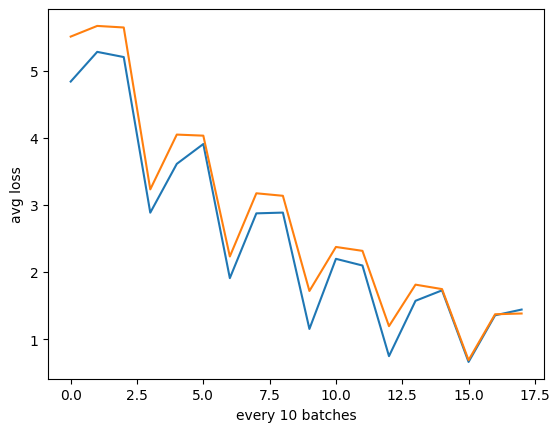

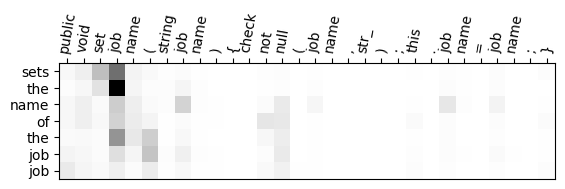

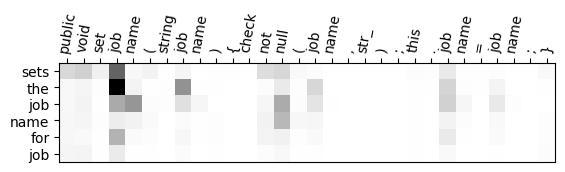

In [ ]:
get_attention_by_project('flink',400,0,181,'./result_images/flink_meta_400_0_181.pdf','./result_images/flink_baseline_400_0_181.pdf')

INFO:root:Epoch 1, batch 0: 4.453578948974609
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 4.4536
INFO:root:Epoch 1, batch 0/16: 4.453578948974609
INFO:root:Epoch 1, batch 1: 4.870140552520752


time:  0h  0min  0s 207ms, remaining:  0h  1min  3s 225ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 4.4536
Epoch 1, batch 0/16: 4.453578948974609


INFO:root:Epoch 1, batch 2: 5.399605751037598
INFO:root:Epoch 1, batch 3: 4.825424671173096
INFO:root:Epoch 1, batch 4: 4.738190174102783
INFO:root:Epoch 1, batch 5: 5.802271366119385
INFO:root:Epoch 1, batch 6: 5.321358680725098
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0253.
INFO:root:Epoch 2, batch 0: 2.8179209232330322
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.8179
INFO:root:Epoch 2, batch 0/16: 2.8179209232330322


Validate completed, avg loss: 5.0253.

time:  0h  0min  4s 401ms, remaining:  0h  3min  4s 802ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.8179
Epoch 2, batch 0/16: 2.8179209232330322


INFO:root:Epoch 2, batch 1: 3.618647575378418
INFO:root:Epoch 2, batch 2: 3.462439775466919
INFO:root:Epoch 2, batch 3: 3.69187593460083
INFO:root:Epoch 2, batch 4: 3.377779245376587
INFO:root:Epoch 2, batch 5: 4.516515254974365
INFO:root:Epoch 2, batch 6: 3.6223795413970947
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0447.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.0457262992858887
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.0457
INFO:root:Epoch 3, batch 0/16: 2.0457262992858887


Validate completed, avg loss: 5.0447.

EarlyStopping counter: 1 out of 5.

time:  0h  0min  8s 787ms, remaining:  0h  3min 14s 320ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.0457
Epoch 3, batch 0/16: 2.0457262992858887


INFO:root:Epoch 3, batch 1: 2.460827112197876
INFO:root:Epoch 3, batch 2: 2.9796297550201416
INFO:root:Epoch 3, batch 3: 3.2026901245117188
INFO:root:Epoch 3, batch 4: 3.1569528579711914
INFO:root:Epoch 3, batch 5: 4.1426215171813965
INFO:root:Epoch 3, batch 6: 2.3038361072540283
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0901.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.3414324522018433
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.3414
INFO:root:Epoch 4, batch 0/16: 1.3414324522018433


Validate completed, avg loss: 5.0901.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 13s 144ms, remaining:  0h  3min 14s 624ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.3414
Epoch 4, batch 0/16: 1.3414324522018433


INFO:root:Epoch 4, batch 1: 1.9407994747161865
INFO:root:Epoch 4, batch 2: 2.1099929809570312
INFO:root:Epoch 4, batch 3: 2.1954495906829834
INFO:root:Epoch 4, batch 4: 2.4684391021728516
INFO:root:Epoch 4, batch 5: 3.075303792953491
INFO:root:Epoch 4, batch 6: 1.3625251054763794
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1484.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.02359938621521
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.0236
INFO:root:Epoch 5, batch 0/16: 1.02359938621521


Validate completed, avg loss: 5.1484.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 17s 372ms, remaining:  0h  3min 11s 262ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.0236
Epoch 5, batch 0/16: 1.02359938621521


INFO:root:Epoch 5, batch 1: 1.6300932168960571
INFO:root:Epoch 5, batch 2: 1.4006534814834595
INFO:root:Epoch 5, batch 3: 1.4763190746307373
INFO:root:Epoch 5, batch 4: 1.855575442314148
INFO:root:Epoch 5, batch 5: 2.4417436122894287
INFO:root:Epoch 5, batch 6: 1.3198299407958984
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2189.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.7304757237434387
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7305
INFO:root:Epoch 6, batch 0/16: 0.7304757237434387


Validate completed, avg loss: 5.2189.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 21s 794ms, remaining:  0h  3min  9s 258ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7305
Epoch 6, batch 0/16: 0.7304757237434387


INFO:root:Epoch 6, batch 1: 1.3651896715164185
INFO:root:Epoch 6, batch 2: 1.0994799137115479
INFO:root:Epoch 6, batch 3: 1.228468418121338
INFO:root:Epoch 6, batch 4: 1.3826762437820435
INFO:root:Epoch 6, batch 5: 1.9037622213363647
INFO:root:Epoch 6, batch 6: 0.9740896821022034
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2943.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.2943.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.366164207458496
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.3662
INFO:root:Epoch 1, batch 0/16: 5.366164207458496
INFO:root:Epoch 1, batch 1: 5.3961896896362305


time:  0h  0min  0s 204ms, remaining:  0h  1min  2s 430ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.3662
Epoch 1, batch 0/16: 5.366164207458496


INFO:root:Epoch 1, batch 2: 5.308790683746338
INFO:root:Epoch 1, batch 3: 5.467874526977539
INFO:root:Epoch 1, batch 4: 5.384806156158447
INFO:root:Epoch 1, batch 5: 5.972762107849121
INFO:root:Epoch 1, batch 6: 6.444921493530273
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4259.
INFO:root:Epoch 2, batch 0: 3.6183125972747803
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 3.6183
INFO:root:Epoch 2, batch 0/16: 3.6183125972747803


Validate completed, avg loss: 5.4259.

time:  0h  0min  4s 457ms, remaining:  0h  3min  7s 151ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 3.6183
Epoch 2, batch 0/16: 3.6183125972747803


INFO:root:Epoch 2, batch 1: 3.9066710472106934
INFO:root:Epoch 2, batch 2: 4.076702117919922
INFO:root:Epoch 2, batch 3: 3.8796637058258057
INFO:root:Epoch 2, batch 4: 4.28297758102417
INFO:root:Epoch 2, batch 5: 4.902693271636963
INFO:root:Epoch 2, batch 6: 3.685835599899292
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4050.
INFO:root:Epoch 3, batch 0: 2.6468493938446045
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.6468
INFO:root:Epoch 3, batch 0/16: 2.6468493938446045


Validate completed, avg loss: 5.4050.

time:  0h  0min  9s  31ms, remaining:  0h  3min 19s 726ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.6468
Epoch 3, batch 0/16: 2.6468493938446045


INFO:root:Epoch 3, batch 1: 2.685786724090576
INFO:root:Epoch 3, batch 2: 2.986518144607544
INFO:root:Epoch 3, batch 3: 3.2965035438537598
INFO:root:Epoch 3, batch 4: 3.5385608673095703
INFO:root:Epoch 3, batch 5: 3.8875889778137207
INFO:root:Epoch 3, batch 6: 2.446896553039551
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4144.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 4, batch 0: 1.6670092344284058
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.6670
INFO:root:Epoch 4, batch 0/16: 1.6670092344284058


Validate completed, avg loss: 5.4144.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 13s 300ms, remaining:  0h  3min 16s 932ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.6670
Epoch 4, batch 0/16: 1.6670092344284058


INFO:root:Epoch 4, batch 1: 2.133326768875122
INFO:root:Epoch 4, batch 2: 2.8775923252105713
INFO:root:Epoch 4, batch 3: 2.3014516830444336
INFO:root:Epoch 4, batch 4: 2.681173086166382
INFO:root:Epoch 4, batch 5: 3.005551338195801
INFO:root:Epoch 4, batch 6: 1.5771950483322144
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4546.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 5, batch 0: 1.162717580795288
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.1627
INFO:root:Epoch 5, batch 0/16: 1.162717580795288


Validate completed, avg loss: 5.4546.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 17s 597ms, remaining:  0h  3min 13s 747ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.1627
Epoch 5, batch 0/16: 1.162717580795288


INFO:root:Epoch 5, batch 1: 1.6332734823226929
INFO:root:Epoch 5, batch 2: 1.6881285905838013
INFO:root:Epoch 5, batch 3: 2.020632266998291
INFO:root:Epoch 5, batch 4: 2.0838193893432617
INFO:root:Epoch 5, batch 5: 2.665966510772705
INFO:root:Epoch 5, batch 6: 1.1480586528778076
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4988.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 6, batch 0: 0.7802944779396057
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7803
INFO:root:Epoch 6, batch 0/16: 0.7802944779396057


Validate completed, avg loss: 5.4988.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 22s 126ms, remaining:  0h  3min 12s 141ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7803
Epoch 6, batch 0/16: 0.7802944779396057


INFO:root:Epoch 6, batch 1: 0.9486144185066223
INFO:root:Epoch 6, batch 2: 1.121668815612793
INFO:root:Epoch 6, batch 3: 1.3143634796142578
INFO:root:Epoch 6, batch 4: 1.576069951057434
INFO:root:Epoch 6, batch 5: 1.8816392421722412
INFO:root:Epoch 6, batch 6: 0.9194902777671814
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5583.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 7, batch 0: 0.4732917845249176
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.4733
INFO:root:Epoch 7, batch 0/16: 0.4732917845249176


Validate completed, avg loss: 5.5583.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 26s 755ms, remaining:  0h  3min 10s 302ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.4733
Epoch 7, batch 0/16: 0.4732917845249176


INFO:root:Epoch 7, batch 1: 0.7418254017829895
INFO:root:Epoch 7, batch 2: 0.7470578551292419
INFO:root:Epoch 7, batch 3: 0.9145328402519226
INFO:root:Epoch 7, batch 4: 1.2038791179656982
INFO:root:Epoch 7, batch 5: 1.5375280380249023
INFO:root:Epoch 7, batch 6: 1.2140997648239136
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6273.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6273.

EarlyStopping counter: 5 out of 5.

Early stop.

MAML: 
Baseline: 


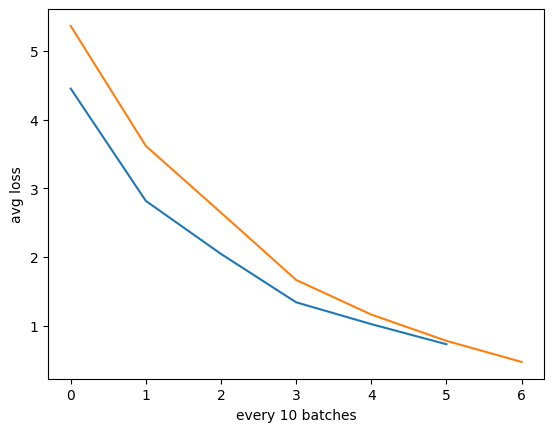

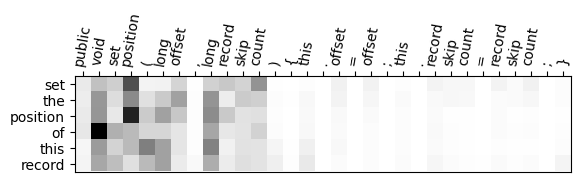

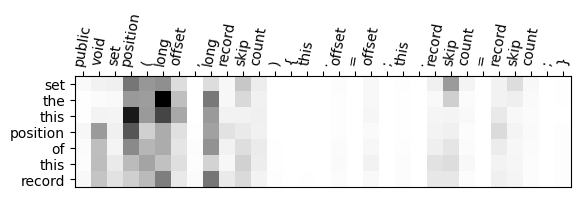

In [ ]:
get_attention_by_project('flink',100,0,43,'./result_images/flink_meta_100_0_43.pdf','./result_images/flink_baseline_100_0_43.pdf')

INFO:root:Epoch 1, batch 0: 5.0171895027160645
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.0172
INFO:root:Epoch 1, batch 0/16: 5.0171895027160645


time:  0h  0min  1s 701ms, remaining:  0h  8min 39s 469ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.0172
Epoch 1, batch 0/16: 5.0171895027160645


INFO:root:Epoch 1, batch 1: 5.045117378234863
INFO:root:Epoch 1, batch 2: 5.293859481811523
INFO:root:Epoch 1, batch 3: 5.032501697540283
INFO:root:Epoch 1, batch 4: 5.271546363830566
INFO:root:Epoch 1, batch 5: 5.380321979522705
INFO:root:Epoch 1, batch 6: 5.081672191619873
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 4.9821.
INFO:root:Epoch 2, batch 0: 2.824960947036743
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.8250
INFO:root:Epoch 2, batch 0/16: 2.824960947036743


Validate completed, avg loss: 4.9821.

time:  0h  0min  6s 289ms, remaining:  0h  4min 24s  41ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.8250
Epoch 2, batch 0/16: 2.824960947036743


INFO:root:Epoch 2, batch 1: 3.543646812438965
INFO:root:Epoch 2, batch 2: 3.550339698791504
INFO:root:Epoch 2, batch 3: 3.7601442337036133
INFO:root:Epoch 2, batch 4: 3.726766586303711
INFO:root:Epoch 2, batch 5: 4.722202777862549
INFO:root:Epoch 2, batch 6: 3.4509541988372803
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0109.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 3, batch 0: 2.1400156021118164
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.1400
INFO:root:Epoch 3, batch 0/16: 2.1400156021118164


Validate completed, avg loss: 5.0109.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 10s 670ms, remaining:  0h  3min 55s 969ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.1400
Epoch 3, batch 0/16: 2.1400156021118164


INFO:root:Epoch 3, batch 1: 2.536529064178467
INFO:root:Epoch 3, batch 2: 2.652212142944336
INFO:root:Epoch 3, batch 3: 2.685373067855835
INFO:root:Epoch 3, batch 4: 3.065825939178467
INFO:root:Epoch 3, batch 5: 3.7822303771972656
INFO:root:Epoch 3, batch 6: 1.8745542764663696
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.0698.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 4, batch 0: 1.3791433572769165
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.3791
INFO:root:Epoch 4, batch 0/16: 1.3791433572769165


Validate completed, avg loss: 5.0698.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 14s 917ms, remaining:  0h  3min 40s 879ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.3791
Epoch 4, batch 0/16: 1.3791433572769165


INFO:root:Epoch 4, batch 1: 1.8538401126861572
INFO:root:Epoch 4, batch 2: 2.217923641204834
INFO:root:Epoch 4, batch 3: 2.1039528846740723
INFO:root:Epoch 4, batch 4: 2.3824405670166016
INFO:root:Epoch 4, batch 5: 2.8376283645629883
INFO:root:Epoch 4, batch 6: 1.5555248260498047
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.1513.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 5, batch 0: 1.161133050918579
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.1611


Validate completed, avg loss: 5.1513.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 19s 332ms, remaining:  0h  3min 32s 844ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.1611


INFO:root:Epoch 5, batch 0/16: 1.161133050918579


Epoch 5, batch 0/16: 1.161133050918579


INFO:root:Epoch 5, batch 1: 1.5163122415542603
INFO:root:Epoch 5, batch 2: 1.1401076316833496
INFO:root:Epoch 5, batch 3: 1.4809340238571167
INFO:root:Epoch 5, batch 4: 1.7261085510253906
INFO:root:Epoch 5, batch 5: 2.211339235305786
INFO:root:Epoch 5, batch 6: 1.1523189544677734
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.2312.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 6, batch 0: 0.7292660474777222
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7293
INFO:root:Epoch 6, batch 0/16: 0.7292660474777222


Validate completed, avg loss: 5.2312.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 23s 798ms, remaining:  0h  3min 26s 658ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7293
Epoch 6, batch 0/16: 0.7292660474777222


INFO:root:Epoch 6, batch 1: 1.0766630172729492
INFO:root:Epoch 6, batch 2: 0.9660841822624207
INFO:root:Epoch 6, batch 3: 1.155914068222046
INFO:root:Epoch 6, batch 4: 1.4554301500320435
INFO:root:Epoch 6, batch 5: 1.9365640878677368
INFO:root:Epoch 6, batch 6: 1.3387006521224976
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3021.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.3021.

EarlyStopping counter: 5 out of 5.

Early stop.



INFO:root:Epoch 1, batch 0: 5.218423366546631
INFO:root:epoch: 1/50, batch: 0/3, avg loss: 5.2184
INFO:root:Epoch 1, batch 0/16: 5.218423366546631


time:  0h  0min  0s 222ms, remaining:  0h  1min  7s 821ms, epoch:  1/50, batch: 0/3, percent complete:   0.33%, avg loss: 5.2184
Epoch 1, batch 0/16: 5.218423366546631


INFO:root:Epoch 1, batch 1: 5.223834991455078
INFO:root:Epoch 1, batch 2: 5.819300651550293
INFO:root:Epoch 1, batch 3: 5.576980113983154
INFO:root:Epoch 1, batch 4: 5.154682159423828
INFO:root:Epoch 1, batch 5: 6.2843546867370605
INFO:root:Epoch 1, batch 6: 6.295305252075195
INFO:root:Validating the model at the end of epoch 0 on valid dataset.



Validating the model at the end of epoch 0 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4327.
INFO:root:Epoch 2, batch 0: 2.9335081577301025
INFO:root:epoch: 2/50, batch: 0/3, avg loss: 2.9335
INFO:root:Epoch 2, batch 0/16: 2.9335081577301025


Validate completed, avg loss: 5.4327.

time:  0h  0min  4s 510ms, remaining:  0h  3min  9s 355ms, epoch:  2/50, batch: 0/3, percent complete:   2.33%, avg loss: 2.9335
Epoch 2, batch 0/16: 2.9335081577301025


INFO:root:Epoch 2, batch 1: 3.4232258796691895
INFO:root:Epoch 2, batch 2: 4.026477813720703
INFO:root:Epoch 2, batch 3: 4.311892509460449
INFO:root:Epoch 2, batch 4: 3.937234401702881
INFO:root:Epoch 2, batch 5: 4.676577091217041
INFO:root:Epoch 2, batch 6: 3.7862138748168945
INFO:root:Validating the model at the end of epoch 1 on valid dataset.



Validating the model at the end of epoch 1 on valid dataset......


INFO:root:Validate completed, avg loss: 5.3962.
INFO:root:Epoch 3, batch 0: 2.4762003421783447
INFO:root:epoch: 3/50, batch: 0/3, avg loss: 2.4762
INFO:root:Epoch 3, batch 0/16: 2.4762003421783447


Validate completed, avg loss: 5.3962.

time:  0h  0min  9s   4ms, remaining:  0h  3min 19s 124ms, epoch:  3/50, batch: 0/3, percent complete:   4.33%, avg loss: 2.4762
Epoch 3, batch 0/16: 2.4762003421783447


INFO:root:Epoch 3, batch 1: 2.5567190647125244
INFO:root:Epoch 3, batch 2: 3.530468225479126
INFO:root:Epoch 3, batch 3: 3.1239888668060303
INFO:root:Epoch 3, batch 4: 3.6195411682128906
INFO:root:Epoch 3, batch 5: 3.6667726039886475
INFO:root:Epoch 3, batch 6: 2.525324821472168
INFO:root:Validating the model at the end of epoch 2 on valid dataset.



Validating the model at the end of epoch 2 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4010.
INFO:root:EarlyStopping counter: 1 out of 5.
INFO:root:Epoch 4, batch 0: 1.6440006494522095
INFO:root:epoch: 4/50, batch: 0/3, avg loss: 1.6440
INFO:root:Epoch 4, batch 0/16: 1.6440006494522095


Validate completed, avg loss: 5.4010.

EarlyStopping counter: 1 out of 5.

time:  0h  0min 13s 424ms, remaining:  0h  3min 18s 768ms, epoch:  4/50, batch: 0/3, percent complete:   6.33%, avg loss: 1.6440
Epoch 4, batch 0/16: 1.6440006494522095


INFO:root:Epoch 4, batch 1: 1.8243118524551392
INFO:root:Epoch 4, batch 2: 2.2569243907928467
INFO:root:Epoch 4, batch 3: 2.563201665878296
INFO:root:Epoch 4, batch 4: 2.678661823272705
INFO:root:Epoch 4, batch 5: 3.3325233459472656
INFO:root:Epoch 4, batch 6: 1.8616280555725098
INFO:root:Validating the model at the end of epoch 3 on valid dataset.



Validating the model at the end of epoch 3 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4311.
INFO:root:EarlyStopping counter: 2 out of 5.
INFO:root:Epoch 5, batch 0: 1.1144107580184937
INFO:root:epoch: 5/50, batch: 0/3, avg loss: 1.1144
INFO:root:Epoch 5, batch 0/16: 1.1144107580184937


Validate completed, avg loss: 5.4311.

EarlyStopping counter: 2 out of 5.

time:  0h  0min 17s 751ms, remaining:  0h  3min 15s 437ms, epoch:  5/50, batch: 0/3, percent complete:   8.33%, avg loss: 1.1144
Epoch 5, batch 0/16: 1.1144107580184937


INFO:root:Epoch 5, batch 1: 1.4196356534957886
INFO:root:Epoch 5, batch 2: 1.7697592973709106
INFO:root:Epoch 5, batch 3: 1.8119741678237915
INFO:root:Epoch 5, batch 4: 2.1142513751983643
INFO:root:Epoch 5, batch 5: 2.745992422103882
INFO:root:Epoch 5, batch 6: 1.495523452758789
INFO:root:Validating the model at the end of epoch 4 on valid dataset.



Validating the model at the end of epoch 4 on valid dataset......


INFO:root:Validate completed, avg loss: 5.4929.
INFO:root:EarlyStopping counter: 3 out of 5.
INFO:root:Epoch 6, batch 0: 0.7185537815093994
INFO:root:epoch: 6/50, batch: 0/3, avg loss: 0.7186
INFO:root:Epoch 6, batch 0/16: 0.7185537815093994


Validate completed, avg loss: 5.4929.

EarlyStopping counter: 3 out of 5.

time:  0h  0min 22s 273ms, remaining:  0h  3min 13s 418ms, epoch:  6/50, batch: 0/3, percent complete:  10.33%, avg loss: 0.7186
Epoch 6, batch 0/16: 0.7185537815093994


INFO:root:Epoch 6, batch 1: 0.972528874874115
INFO:root:Epoch 6, batch 2: 1.2166987657546997
INFO:root:Epoch 6, batch 3: 1.3806283473968506
INFO:root:Epoch 6, batch 4: 1.515864372253418
INFO:root:Epoch 6, batch 5: 1.8911091089248657
INFO:root:Epoch 6, batch 6: 0.8339559435844421
INFO:root:Validating the model at the end of epoch 5 on valid dataset.



Validating the model at the end of epoch 5 on valid dataset......


INFO:root:Validate completed, avg loss: 5.5462.
INFO:root:EarlyStopping counter: 4 out of 5.
INFO:root:Epoch 7, batch 0: 0.4048195481300354
INFO:root:epoch: 7/50, batch: 0/3, avg loss: 0.4048
INFO:root:Epoch 7, batch 0/16: 0.4048195481300354


Validate completed, avg loss: 5.5462.

EarlyStopping counter: 4 out of 5.

time:  0h  0min 26s 828ms, remaining:  0h  3min 10s 817ms, epoch:  7/50, batch: 0/3, percent complete:  12.33%, avg loss: 0.4048
Epoch 7, batch 0/16: 0.4048195481300354


INFO:root:Epoch 7, batch 1: 0.7830430865287781
INFO:root:Epoch 7, batch 2: 0.8087764978408813
INFO:root:Epoch 7, batch 3: 0.9238632321357727
INFO:root:Epoch 7, batch 4: 1.3566310405731201
INFO:root:Epoch 7, batch 5: 1.7548737525939941
INFO:root:Epoch 7, batch 6: 0.8652933239936829
INFO:root:Validating the model at the end of epoch 6 on valid dataset.



Validating the model at the end of epoch 6 on valid dataset......


INFO:root:Validate completed, avg loss: 5.6083.
INFO:root:EarlyStopping counter: 5 out of 5.
INFO:root:Early stop.


Validate completed, avg loss: 5.6083.

EarlyStopping counter: 5 out of 5.

Early stop.

MAML: 
Baseline: 


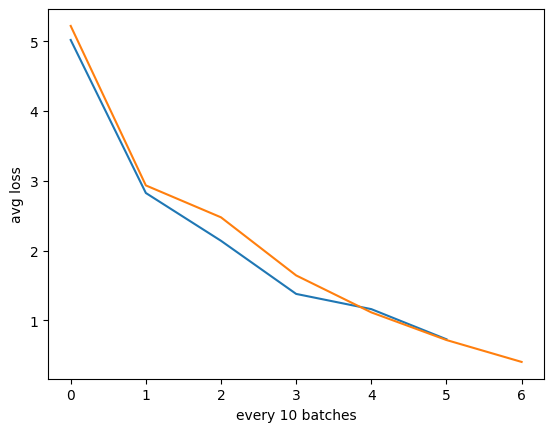

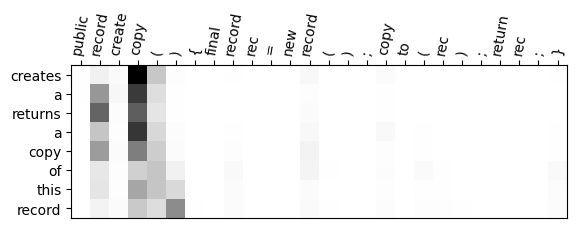

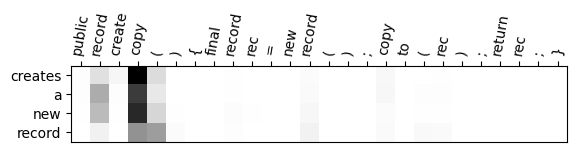

In [ ]:
get_attention_by_project('flink',100,0,334,'./result_images/flink_meta_100_0_334.pdf','./result_images/flink_baseline_100_0_334.pdf')